In [1]:
from ipywidgets import interact
import fabio
from skimage.measure import compare_ssim as ssim
import cv2
import PyMca5 as mca
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
edfdir = '/Users/ezatterin/Documents/UCL_phd/data/ESRF/HC_2615/detector/align2/'
specdir = '/Users/ezatterin/Documents/UCL_phd/data/ESRF/HC_2615/spec/'

Load scans in `scan_total`

In [22]:
scan_numbers = [8]
scan_total = []

for scan_no in scan_numbers:
    
    # Load specfile
    sf = mca.specfilewrapper.Specfile(specdir+'align2.spec')
    # Specify scan number and load it
    scan = sf[scan_no-1]
    # Find out how many images the scan contains
    edf_num = scan.alllabels().index('mpx4inr')
    img_num = scan.data()[edf_num].shape[0]
    # Find the filename of the first edf file of the scan
    fname0 = scan.header('ULIMA')[0].split('/')[-1]
    # Load the first edf file
    edf0 = fabio.open(edfdir + fname0)
    # Load the rest of the edf files in the scan and place them in an array
    scan_all = [edf0]
    for n in range(img_num-1):
        scan_all.append(scan_all[n].next())
    scan_all = np.array(scan_all)
    scan_total.append(scan_all)

# scan_total = np.array(scan_total) # Place all the image containers in an array.

I take the same pixel in each image and plot the variation of its intensity across images:

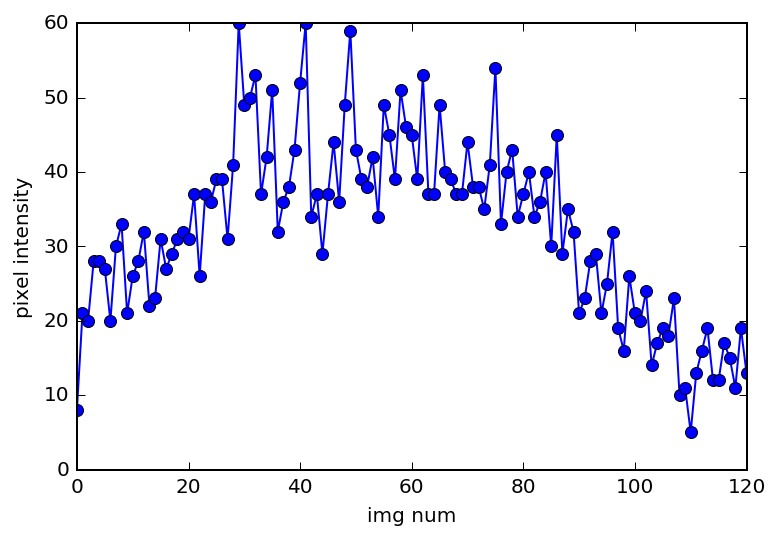

In [31]:
# array of edf images for one scan
img_array = scan_total[0]
# variation of intensity of one pixel across images
pixel_time = []
for image in img_array:
    pixel_time.append(image.data[130,110])
plt.plot(pixel_time, '-o')
plt.ylabel('pixel intensity')
plt.xlabel('img num');

$$ \dfrac{\dfrac{1}{N} \sum_N I_{\text{px}}(N) \cdot I_{\text{px}}(N + 1)}{(\dfrac{1}{N} \sum_N I(N))^2} $$

In [32]:
def acf1d(px_array):
    
    acf = []
    for px_index in range(len(px_array)-2):
        product = []
        while px_index <= len(px_array)-2:
            product.append(px_array[px_index]*px_array[px_index+1]) 
            px_index = px_index + 1
        corr = np.array(product).mean()
        norm=np.array(px_array).mean()**2
        corr = corr / norm
        acf.append(corr)
    
    acf = np.array(acf)
    return acf

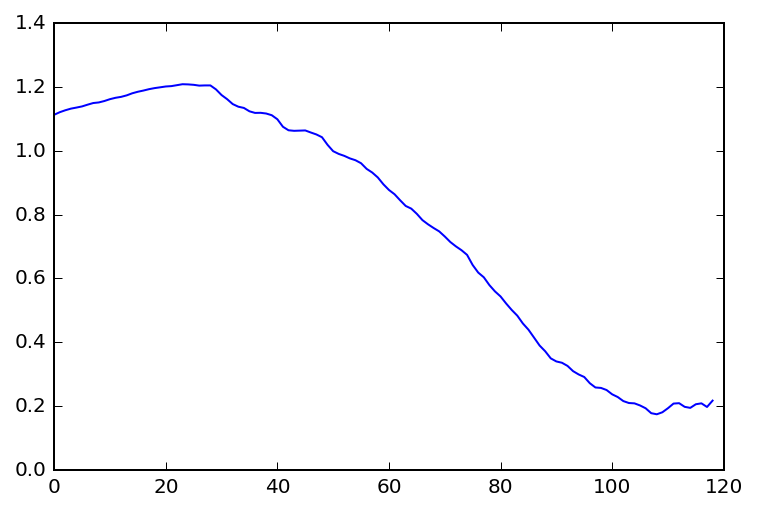

In [33]:
plt.plot(acf1d(pixel_time))

Stack images in 3d array (prob should do this always!):

In [205]:
img_array_list = []
for entry in img_array:
    img_array_list.append(entry.data)
img_array_list = tuple(img_array_list)
stack = np.dstack(img_array_list) + 0.1

Great. now what.

In [119]:
a = np.array([[1,2],[3,4]])
a[0,:]

array([1, 2])

In [187]:
def acf1d(px_array):
    
    acf = []
    for px_index in range(len(px_array)-2):
        product = []
        while px_index <= len(px_array)-2:
            product.append(px_array[px_index]*pixel_time[px_index+1]) 
            px_index = px_index + 1
        corr = np.array(product).mean()
        norm=np.array(px_array).mean()**2
        corr = corr / norm
        acf.append(corr)
    
    acf = np.array(acf)
    return acf

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


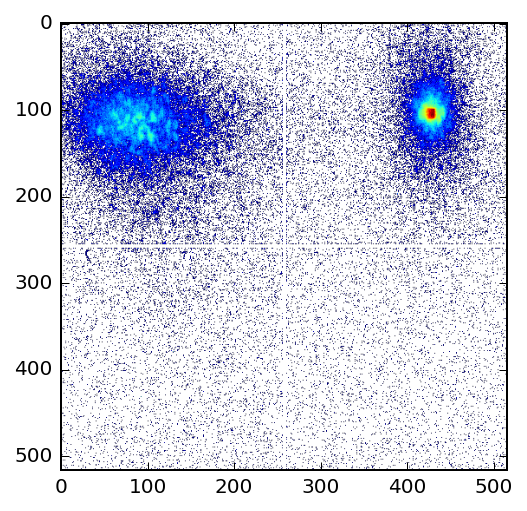

In [190]:
plt.imshow(np.log(stack[:,:,0]))

In [206]:
res = np.ones((30,30,119))
for i in range(85,114):
    # select a row
    for j in range(85,114):
        # select a pixel: a 1d array over imgs/time        
        res[i-85,j-85] = acf1d(stack[i,j])

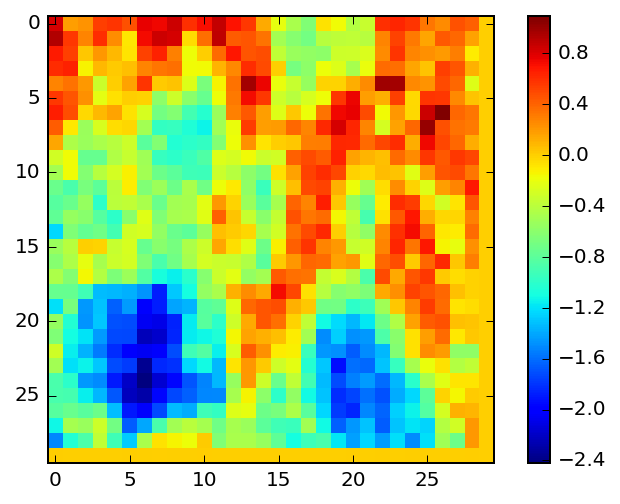

In [208]:
@interact(i=(0,120))
def plt_stuff(i):
    plt.imshow(np.log(res[:,:,i]),interpolation='none')
    plt.colorbar()

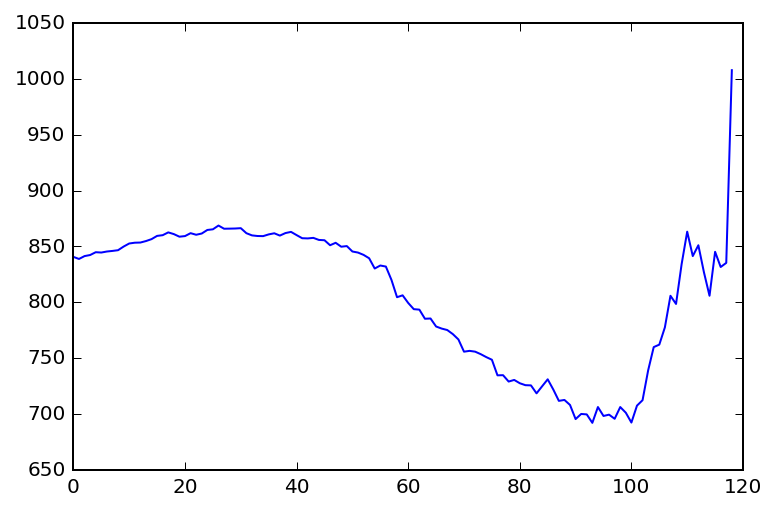

In [211]:
plt.plot(res.sum(axis=1).sum(axis=0))